# PyMC test

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.1


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Generating Data

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

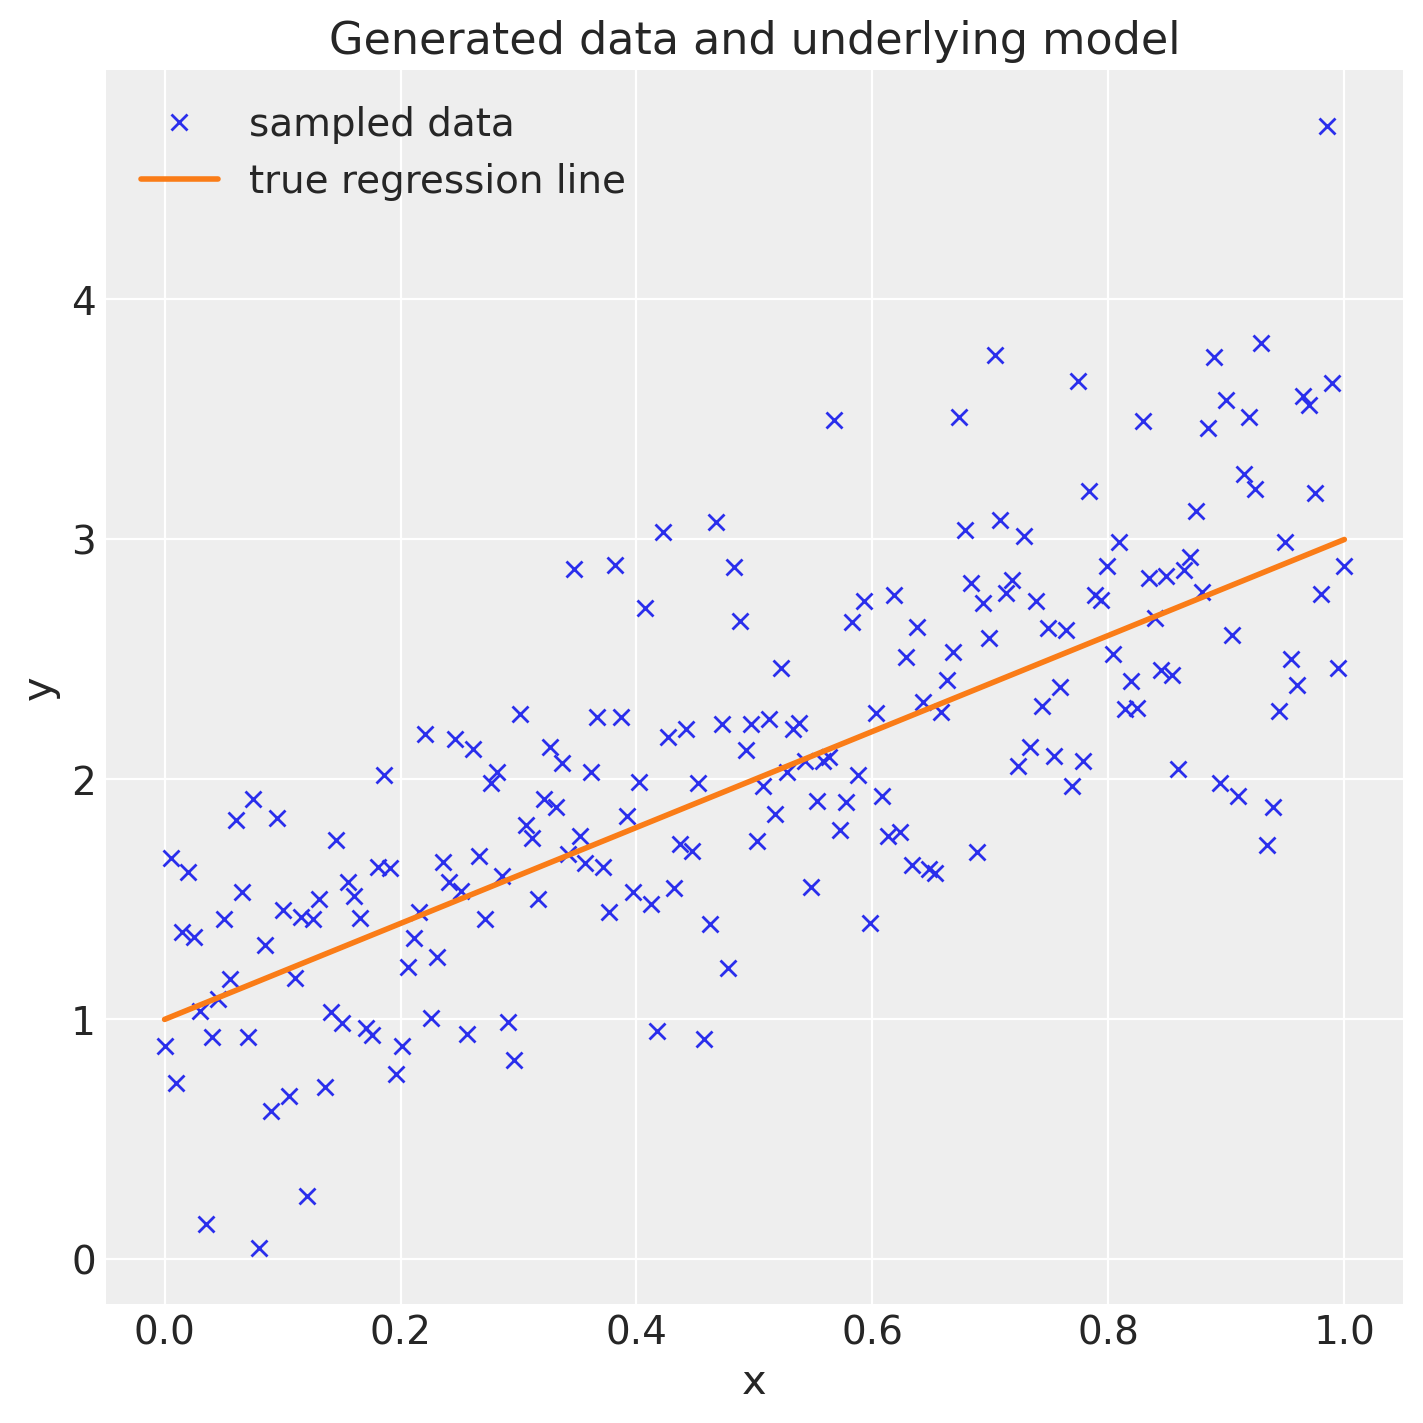

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

# Estimating

In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


# Analyze

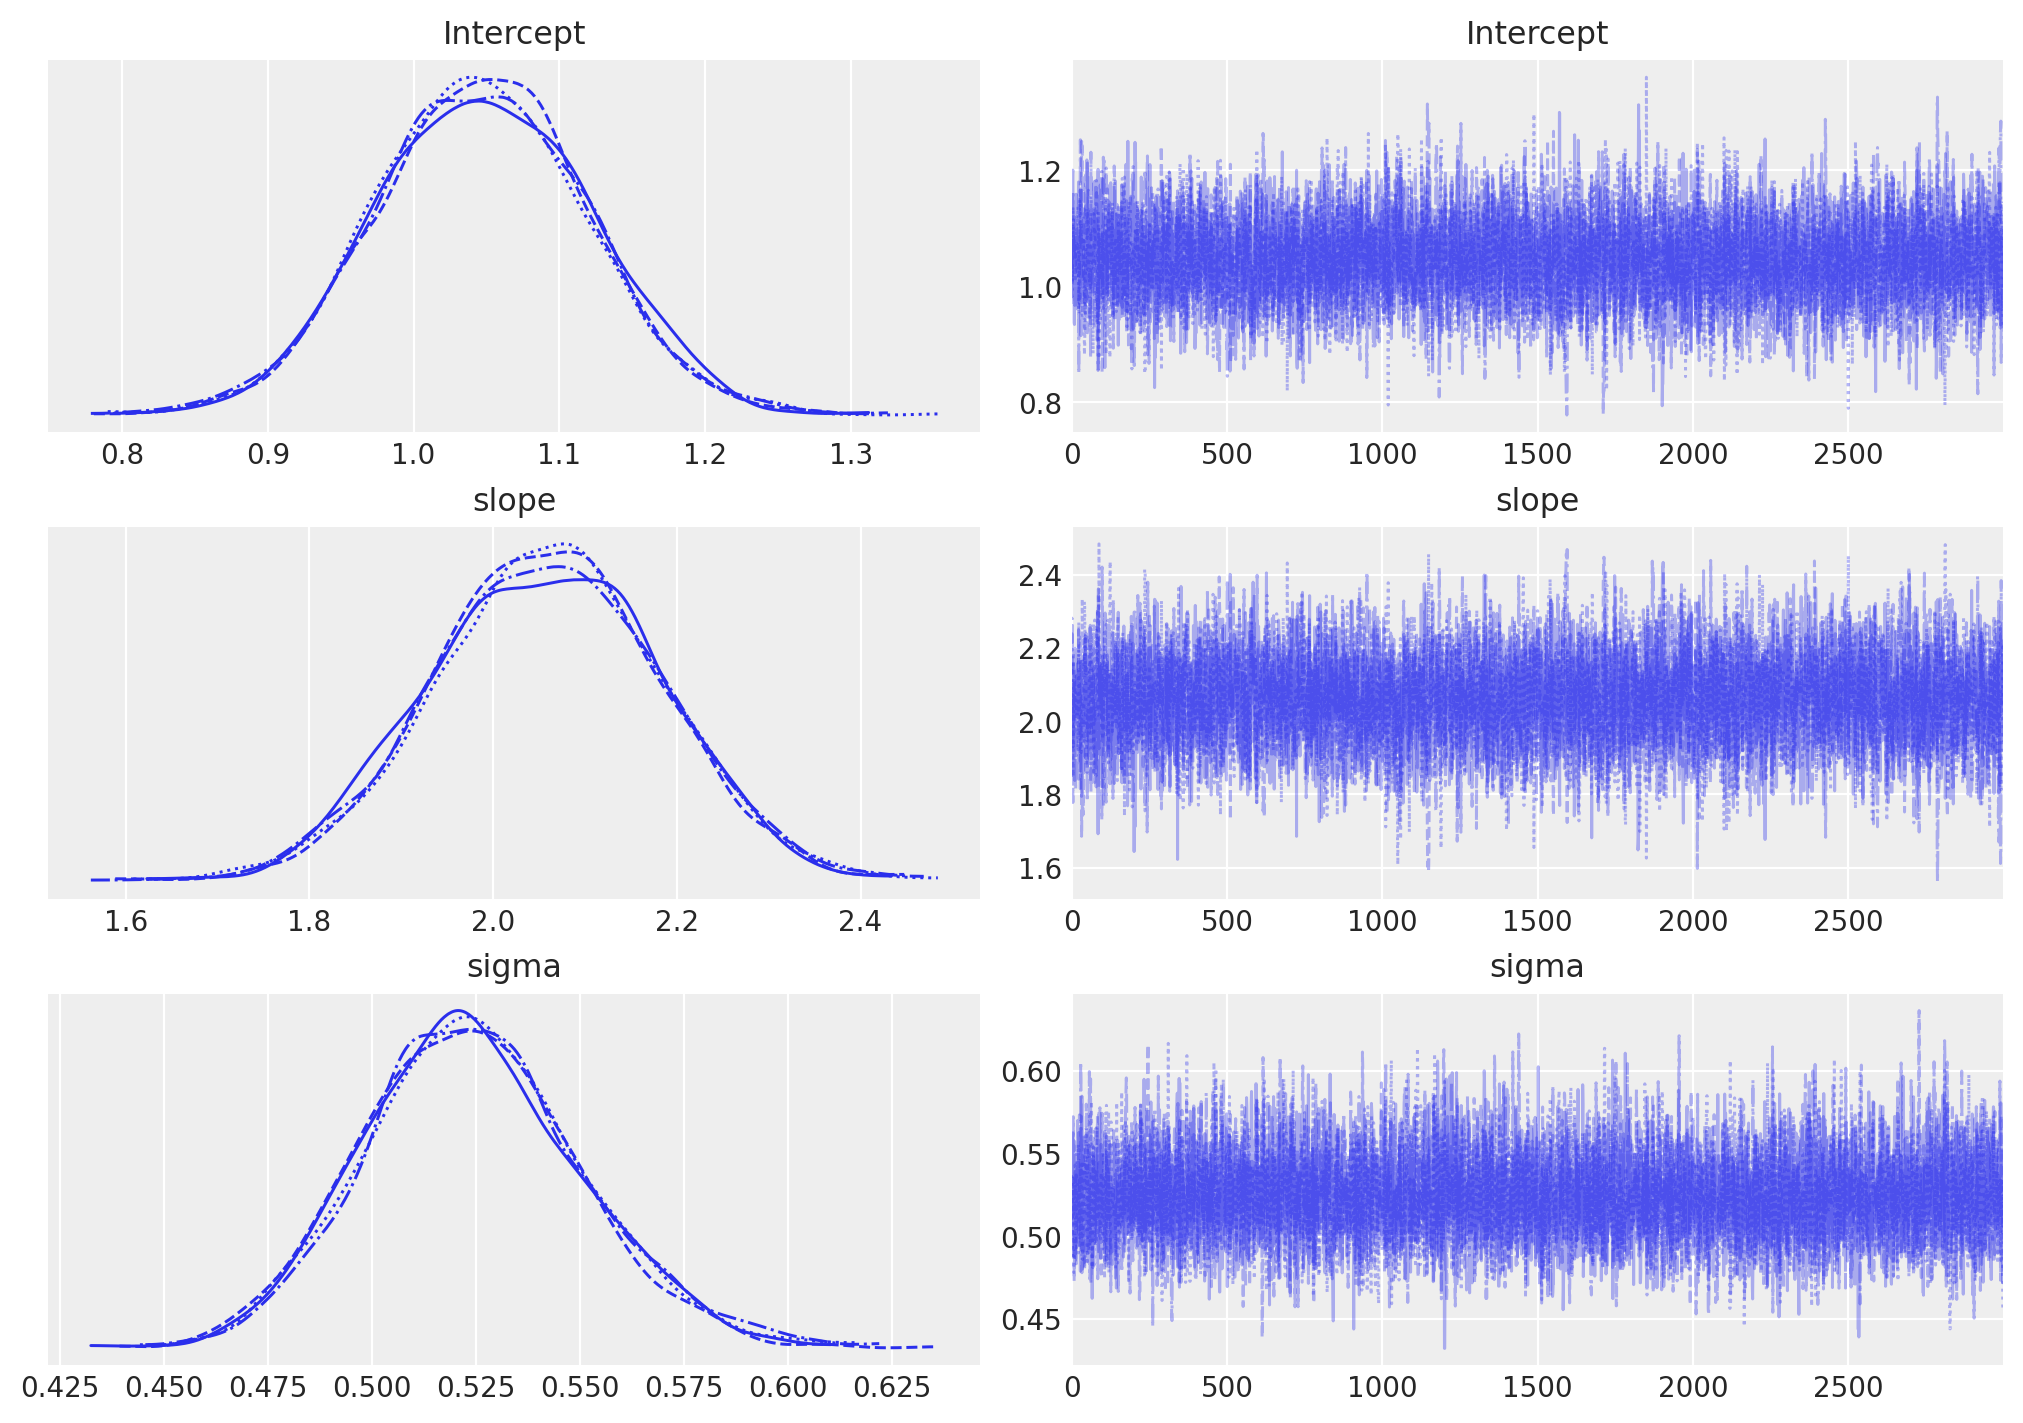

In [6]:
az.plot_trace(idata, figsize=(10, 7));

In [7]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

KeyError: "No variable named 'x'. Variables on the dataset include ['chain', 'draw', 'Intercept', 'slope', 'sigma']"

In [8]:
idata.posterior.keys()

KeysView(<xarray.Dataset>
Dimensions:    (chain: 4, draw: 3000)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 ... 2993 2994 2995 2996 2997 2998 2999
Data variables:
    Intercept  (chain, draw) float64 1.088 0.9724 1.143 ... 0.9431 1.133 1.146
    slope      (chain, draw) float64 1.92 2.239 1.851 ... 2.287 1.921 1.949
    sigma      (chain, draw) float64 0.5305 0.5225 0.5369 ... 0.5093 0.507
Attributes:
    created_at:                 2024-01-10T16:50:21.184716
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              2.199964761734009
    tuning_steps:               1000)

In [ ]:
idata.